# Dynamic Risk Budgeting

#### ** Make sure you download the 'erk.py' first

In [117]:
import numpy as np 
import pandas as pd
import erk as erk
%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
n_scenarios=5000
rates, zc_prices= erk.cir(10,n_scenarios=n_scenarios,b=0.03, r_0=0.03, sigma=0.02)
price_eq= erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

## CPPI_based Allocator

In [100]:
rets_floor75= erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
pd.concat([
    erk.terminal_stats(rets_zc,name="ZC",floor=0.75),
    erk.terminal_stats(rets_eq, name="Equity",floor=0.75),
    erk.terminal_stats(rets_7030b,name="70/30",floor=0.75),
    erk.terminal_stats(rets_floor75,name="Floor75",floor=0.75)],
    axis=1).round(2)

,ZC,Equity,70/30,Floor75
mean,1.34,2.02,1.79,2.00
std,0.00,1.00,0.61,1.01
p-breach,NaN,0.03,0.01,0.00
e-shortfall,NaN,0.11,0.08,0.02
p-reach,NaN,NaN,NaN,NaN
e-surplus,NaN,NaN,NaN,NaN


Conclusion:

Based on above statistics, CPPI_based dynamic risk budgeting algorithm does work very well! 
1. 'Floor75' only gave up 0.02% return (compared with 100% equity) in exchange for no breach at all 
2. Also, 'Floor75' successfully avioded 8% expected shortfall if breach
3. Actually, it outperforms not only fixedmix allocator but also glide allocator
-
-
-
Next, what if we increase the multipler m? 



In [101]:
rets_floor75m1= erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:],m=1)
rets_floor75m5= erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:],m=5)
pd.concat([
    erk.terminal_stats(rets_zc,name="ZC",floor=0.75),
    erk.terminal_stats(rets_eq, name="Equity",floor=0.75),
    erk.terminal_stats(rets_7030b,name="70/30",floor=0.75),
    erk.terminal_stats(rets_floor75,name="Floor75m3",floor=0.75),
    erk.terminal_stats(rets_floor75m1,name="Floor75m1",floor=0.75),
    erk.terminal_stats(rets_floor75m5,name="Floor75m5",floor=0.75)],
    axis=1).round(4)

,ZC,Equity,70/30,Floor75m3,Floor75m1,Floor75m5
mean,1.3433,2.0190,1.7875,1.9956,1.6425,2.0062
std,0.0000,1.0000,0.6052,1.0062,0.4420,1.0079
p-breach,NaN,0.0344,0.0068,0.0016,NaN,0.0106
e-shortfall,NaN,0.1127,0.0799,0.0205,NaN,0.0186
p-reach,NaN,NaN,NaN,NaN,NaN,NaN
e-surplus,NaN,NaN,NaN,NaN,NaN,NaN


## Now, Risk Budgeting with Drawdown Allocator

In [102]:
cashrate=0.02
monthly_cashreturn= (1+cashrate)**(1/12)-1
rets_cash= pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25=erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25)
tv_maxdd25=erk.terminal_values(rets_maxdd25)
pd.concat([
    erk.terminal_stats(rets_zc,name="ZC",floor=0.75),
    erk.terminal_stats(rets_eq, name="Equity",floor=0.75),
    erk.terminal_stats(rets_7030b,name="70/30",floor=0.75),
    erk.terminal_stats(rets_floor75,name="Floor75m3",floor=0.75),
    erk.terminal_stats(rets_floor75m1,name="Floor75m1",floor=0.75),
    erk.terminal_stats(rets_floor75m5,name="Floor75m5",floor=0.75),
    erk.terminal_stats(rets_maxdd25,name="MaxDD25",floor=0.25)],
    axis=1).round(3)

,ZC,Equity,70/30,Floor75m3,Floor75m1,Floor75m5,MaxDD25
mean,1.343,2.019,1.787,1.996,1.642,2.006,1.657
std,0.000,1.000,0.605,1.006,0.442,1.008,0.551
p-breach,NaN,0.034,0.007,0.002,NaN,0.011,NaN
e-shortfall,NaN,0.113,0.080,0.020,NaN,0.019,NaN
p-reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e-surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.191645
1   -0.144960
2   -0.122357
3   -0.191993
4   -0.182053
Name: Max Drawdown, dtype: float64

### So, what is the worst drawdown?

In [104]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23694663727550216

Therefore, by using the Drawdown Allocator, we did achieve our goal of limiting the maxdrawn below 25%

## Then see the distribution of terminal values of different methods above.

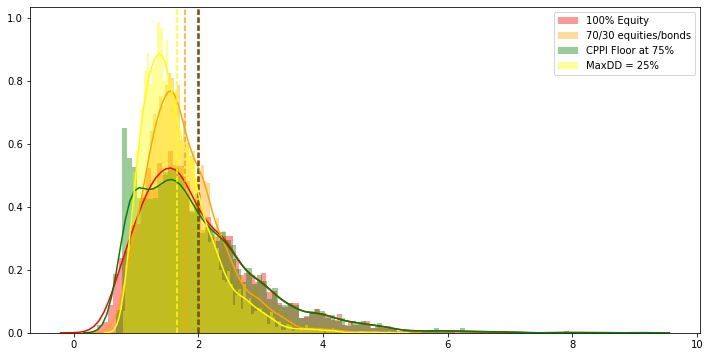

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
tv_eq= erk.terminal_values(rets_eq)
tv_zc=erk.terminal_values(rets_zc)
tv_7030b=erk.terminal_values(rets_7030b)
tv_floor75=erk.terminal_values(rets_floor75)
tv_maxdd25=erk.terminal_values(rets_maxdd25)
# plot
plt.figure(figsize=(12,6))
sns.distplot(tv_eq, color="red",label="100% Equity", bins=100)
plt.axvline(tv_eq.mean(),ls="--", color="red")

sns.distplot(tv_7030b, color="orange",label="70/30 equities/bonds", bins=100)
plt.axvline(tv_7030b.mean(),ls="--", color="orange")

sns.distplot(tv_floor75, color="green",label="CPPI Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(),ls="--", color="green")

sns.distplot(tv_maxdd25, color="yellow",label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(),ls="--", color="yellow")
plt.legend();

# Drawdown constraints with Historical Data

First, take a look at historical market performance after 1990s

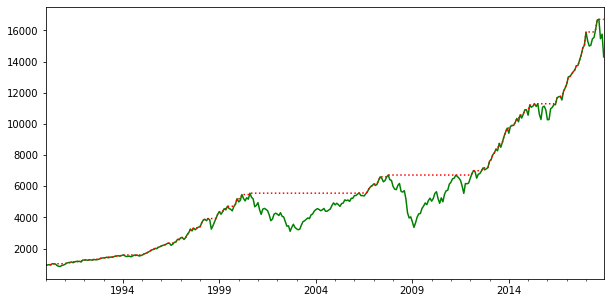

In [106]:
rets_tmi=erk.get_total_market_index_returns()["1990":]
dd_tmi=erk.drawdown(rets_tmi)
ax= dd_tmi["Wealth"].plot(figsize=(10,5),ls="-", color="green")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="red")

### Now, use our maxdrawdown allocator on the real data, 'US market after 1990'

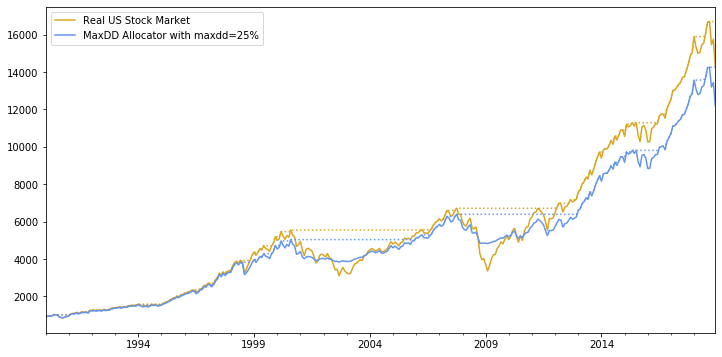

In [107]:
cashrate=0.03
monthly_cashreturn=(1+cashrate)**(1/12)-1
rets_cash= pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25= erk.bt_mix(pd.DataFrame(rets_tmi),rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25, m=5)
dd_25= erk.drawdown(rets_maxdd25[0])

ax=dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Real US Stock Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD Allocator with maxdd=25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

##### Then, see the statistics

In [108]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Returns,Annualized Vol,Skewness,Kurtosis,Corner_Fisher Var (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212


Conclusion:
1. We succeeded in reducing Max Drawdown from 50% to 25% in real historic data
2. In terms of annualized returns, we gave up only 0.6% (from 9.6% to 9%)